In [1]:
import seaborn as sns
import metapack as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display 

%matplotlib inline
sns.set_context('notebook')
mp.jupyter.init()


In [2]:
#pkg = mp.jupyter.open_package()
pkg = mp.jupyter.open_source_package()

pkg.set_sys_path()
from pylib import *

pkg

# Arrest Records for NY, DC and LA
`aei-crime-ny_la_dc-source-1.1.1` Last Update: 2023-06-30T14:13:18

_Complete Multiyear Arrest Records for Los Angeles, New York City, and Washington, DC_


## Documentation Links

* [documentation](docs/DT7-Documentation.pdf) Blog post and data dictionary
* [Home page](https://www.aei.org/research-products/working-paper/data-tools-7-complete-multiyear-arrest-records-for-los-angeles-new-york-city-and-washington-dc/) 

 


## Resources

* ** [zips](https://www.aei.org/wp-content/uploads/2023/06/LawanyZips-1.csv)**. Each ZIP code, including its demographic characteristics and inhabitants’ educational attainment, household income, and family structure.
* ** [arrests](https://www.aei.org/wp-content/uploads/2023/06/LawanyArrests.zip?x91208)**. Complete multi-year arrests records for Los Angeles, New York, and Washington, DC

In [3]:
df = pkg.resource('arrests').dataframe()
zips  = pkg.resource('zips').dataframe()

# 'station' indicates if the location is near a police station, which usually
# means that the crime position record is not where the crime actially occurred

df = df[df.station == 0]


In [26]:
df['race'] = df.race.replace(
{'2 Black': 'black',
 '3 Latino': 'latino',
 '1 N-L White': 'nhwhite',
 '6 Unknown': 'unk',
 '4 Asian': 'asian',
 '5 Other': 'other'})

In [9]:

weapons = [ e for e in df.pdcharge.fillna('').unique() if 'WEAPON' in e]

df['is_homicide'] = df.indexcrimes=='1 Murder'
df['is_weapons'] = df.pdcharge.isin(weapons)
df['is_assault'] = df.indexcrimes=='4 Aggravated Assault'


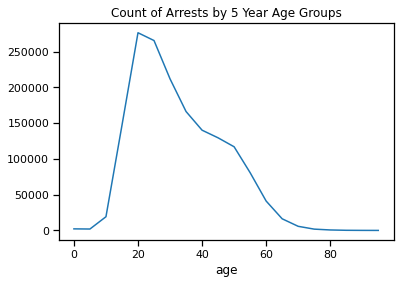

In [10]:
df.groupby((df.age//5)*5).pdid.count().plot(title='Count of Arrests by 5 Year Age Groups');

In [60]:
t = df[df.is_homicide].groupby(['zip','race']).pdid.count().to_frame().unstack()
t = t.droplevel(0, axis=1).fillna(0)

ts = t.sum(axis=1)
t = t.divide(ts, axis=0)
t.rename(columns=lambda v: v+'_hom')

race,asian_hom,black_hom,latino_hom,nhwhite_hom,other_hom,unk_hom
zip,,,,,,
10001,0.000000,0.857143,0.000000,0.071429,0.000000,0.071429
10002,0.357143,0.428571,0.214286,0.000000,0.000000,0.000000
10003,0.000000,0.666667,0.238095,0.047619,0.000000,0.047619
10005,0.000000,0.333333,0.000000,0.666667,0.000000,0.000000
10007,0.026549,0.610619,0.336283,0.017699,0.000000,0.008850
...,...,...,...,...,...,...
91602,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
91604,0.000000,0.142857,0.142857,0.428571,0.285714,0.000000
91605,0.000000,0.031250,0.812500,0.093750,0.062500,0.000000


In [17]:
df[df.is_homicide][['race','sex']].value_counts()

race         sex   
2 Black      Male      4433
3 Latino     Male      2257
1 N-L White  Male       392
2 Black      Female     340
3 Latino     Female     211
4 Asian      Male       148
5 Other      Male        99
1 N-L White  Female      54
6 Unknown    Male        36
4 Asian      Female      13
5 Other      Female      11
6 Unknown    Female       3
dtype: int64

In [12]:
g = df[df.is_homicide].groupby(['year','zip']).pdid.count().to_frame("arr_n").reset_index()

dfz = zips[['zip','totalpop','pblack','pnlwhite','pchild1parent']]

t = g.merge(dfz,on='zip')
t['arr_rate'] = (t.arr_n.astype(float)/t.totalpop)
t['wb_ratio'] = 1/(t.pnlwhite/t.pblack)
t.drop(columns=['year']).corr()

,zip,arr_n,totalpop,pblack,pnlwhite,pchild1parent,arr_rate,wb_ratio
zip,1.000000,-0.035932,-0.234669,-0.403663,-0.037285,-0.100177,0.026799,-0.128720
arr_n,-0.035932,1.000000,0.135275,0.214394,-0.213647,0.300882,0.547182,0.266578
totalpop,-0.234669,0.135275,1.000000,0.152318,-0.286078,0.197436,-0.302302,0.147720
pblack,-0.403663,0.214394,0.152318,1.000000,-0.487955,0.544967,0.053585,0.637881
pnlwhite,-0.037285,-0.213647,-0.286078,-0.487955,1.000000,-0.711045,-0.010677,-0.502191
pchild1parent,-0.100177,0.300882,0.197436,0.544967,-0.711045,1.000000,0.084085,0.451205
arr_rate,0.026799,0.547182,-0.302302,0.053585,-0.010677,0.084085,1.000000,0.059062
wb_ratio,-0.128720,0.266578,0.147720,0.637881,-0.502191,0.451205,0.059062,1.000000


In [13]:
t

,year,zip,arr_n,totalpop,pblack,pnlwhite,pchild1parent,arr_rate,wb_ratio
0,2006,10007,8,8194,0.089822,0.662680,0.026363,0.000976,0.135543
1,2007,10007,2,8194,0.089822,0.662680,0.026363,0.000244,0.135543
2,2008,10007,5,8194,0.089822,0.662680,0.026363,0.00061,0.135543
3,2009,10007,4,8194,0.089822,0.662680,0.026363,0.000488,0.135543
4,2010,10007,2,8194,0.089822,0.662680,0.026363,0.000244,0.135543
...,...,...,...,...,...,...,...,...,...
2321,2021,20015,1,15677,0.098616,0.661160,0.115182,0.000064,0.149156
2322,2022,10044,1,12155,0.130070,0.397532,0.137833,0.000082,0.327194
2323,2022,10471,1,23387,0.105016,0.558644,0.151338,0.000043,0.187983
2324,2022,11215,1,73419,0.037238,0.661845,0.137713,0.000014,0.056264


<AxesSubplot:xlabel='pnlwhite', ylabel='Density'>

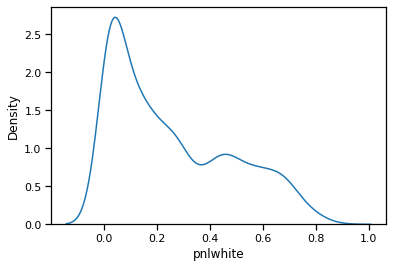

In [14]:
sns.kdeplot(data=t, x="pnlwhite")

In [15]:
df[~df.is_homicide].indexcrimes.value_counts()

4 Aggravated Assault     283725
3 Robbery                147527
6 Larceny                 98104
5 Burglary                73532
7 Motor Vehicle Theft     49937
2 Rape                     7030
8 Arson                    2888
Name: indexcrimes, dtype: int64

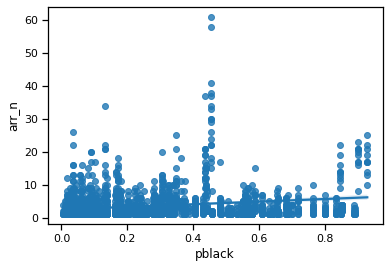

In [16]:
sns.regplot(x="pblack", y="arr_n", data=t);